Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone --single-branch --branch jupiter_niri https://github.com/Nat1405/deep-image-prior
!mv deep-image-prior/* ./
!pip install -U tensorboard 
!rm -r runs

fatal: destination path 'deep-image-prior' already exists and is not an empty directory.
mv: cannot stat 'deep-image-prior/*': No such file or directory
Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.3.0)


# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from skimage.measure import compare_mse
from models.downsampler import Downsampler

from utils.sr_utils import *

from torch.utils.tensorboard import SummaryWriter

import astropy.io.fits as fits

def put_in_center(img_np, target_size):
    img_out = np.zeros([3, target_size[0], target_size[1]])

    bbox = [
            int((target_size[0] - img_np.shape[1]) / 2),
            int((target_size[1] - img_np.shape[2]) / 2),
            int((target_size[0] + img_np.shape[1]) / 2),
            int((target_size[1] + img_np.shape[2]) / 2),
    ]

    img_out[:, bbox[0]:bbox[2], bbox[1]:bbox[3]] = img_np

    return img_out


def load_LR_HR_imgs_sr(fname, imsize, factor, enforse_div32=None):
    '''Loads an image, resizes it, center crops and downscales.

    Args: 
        fname: path to the image
        imsize: new size for the image, -1 for no resizing
        factor: downscaling factor
        enforse_div32: if 'CROP' center crops an image, so that its dimensions are divisible by 32.
    '''
    img_orig_pil, img_orig_np = get_image(fname, -1)

    if imsize != -1:
        img_orig_pil, img_orig_np = get_image(fname, imsize)

    # For comparison with GT
    if enforse_div32 == 'CROP':
        new_size = (img_orig_pil.size[0] - img_orig_pil.size[0] % 32, 
                    img_orig_pil.size[1] - img_orig_pil.size[1] % 32)

        bbox = [
                (img_orig_pil.size[0] - new_size[0])/2, 
                (img_orig_pil.size[1] - new_size[1])/2,
                (img_orig_pil.size[0] + new_size[0])/2,
                (img_orig_pil.size[1] + new_size[1])/2,
        ]

        img_HR_pil = img_orig_pil.crop(bbox)
        img_HR_np = pil_to_np(img_HR_pil)
    else:
        img_HR_pil, img_HR_np = img_orig_pil, img_orig_np

    LR_size = [
               img_HR_pil.size[0] // factor, 
               img_HR_pil.size[1] // factor
    ]

    img_LR_pil = img_HR_pil.resize(LR_size, Image.ANTIALIAS)
    img_LR_np = pil_to_np(img_LR_pil)

    print('HR and LR resolutions: %s, %s' % (str(img_HR_pil.size), str (img_LR_pil.size)))

    return {
                'orig_pil': img_orig_pil,
                'orig_np':  img_orig_np,
                'LR_pil':  img_LR_pil, 
                'LR_np': img_LR_np,
                'HR_pil':  img_HR_pil, 
                'HR_np': img_HR_np
           }

def load_multiple_LR_HR_imgs_sr(fnames):
    img_LR_nps = []
    for fname in fnames:
        with fits.open(fname) as hdu_list:
            img_LR_nps.append(np.flipud(hdu_list['SCI'].data.astype(np.float32)).copy())

    return img_LR_nps

def tv_loss(x, beta = 0.5):
    '''Calculates TV loss for an image `x`.

    Args:
        x: image, torch.Variable of torch.Tensor
        beta: See https://arxiv.org/abs/1412.0035 (fig. 2) to see effect of `beta` 
    '''
    dh = torch.pow(x[:,:,:,1:] - x[:,:,:,:-1], 2)
    dw = torch.pow(x[:,:,1:,:] - x[:,:,:-1,:], 2)

    return torch.sum(torch.pow(dh[:, :, :-1] + dw[:, :, :, :-1], beta))

def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.

    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params

def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False
        
    return net_input

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.

    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        
        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False
        
def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'ResNet':
        # TODO
        net = ResNet(input_depth, 3, 10, 16, 1, nn.BatchNorm2d, False)
    elif NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11, 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)

    elif NET_TYPE == 'texture_nets':
        net = get_texture_nets(inp=input_depth, ratios = [32, 16, 8, 4, 2, 1], fill_noise=False,pad=pad)

    elif NET_TYPE =='UNet':
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode=upsample_mode, pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
    elif NET_TYPE == 'identity':
        assert input_depth == 3
        net = nn.Sequential()
    else:
        assert False

    return net

class ListModule(nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        if idx < 0: 
            idx = len(self) + idx

        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)

def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
    
torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)


class GenNoise(nn.Module):
    def __init__(self, dim2):
        super(GenNoise, self).__init__()
        self.dim2 = dim2

    def forward(self, input):
        a = list(input.size())
        a[1] = self.dim2
        # print (input.data.type())

        b = torch.zeros(a).type_as(input.data)
        b.normal_()

        x = torch.autograd.Variable(b)

        return x


class Swish(nn.Module):
    """
        https://arxiv.org/abs/1710.05941
        The hype was so huge that I could not help but try it
    """
    def __init__(self):
        super(Swish, self).__init__()
        self.s = nn.Sigmoid()

    def forward(self, x):
        return x * self.s(x)


def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()


def bn(num_features):
    return nn.BatchNorm2d(num_features)


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':

        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        elif downsample_mode  in ['lanczos2', 'lanczos3']:
            downsampler = Downsampler(n_planes=out_f, factor=stride, kernel_type=downsample_mode, phase=0.5, preserve_size=True)
        else:
            assert False

        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)


    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)

class Downsampler(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()
        
        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'
            
            
        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        
        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch       

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1: 
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)
                
            self.padding = nn.ReplicationPad2d(pad)
        
        self.preserve_size = preserve_size
        
    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)
        
def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']
    
    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box': 
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])
    
        
    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)
        
    elif kernel_type == 'gauss': 
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        
        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos': 
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                
                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor  
                    dj = abs(j + 0.5 - center) / factor 
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor
                
                
                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)
                
                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                
                kernel[i - 1][j - 1] = val
            
        
    else:
        assert False, 'wrong method name'
    
    kernel /= kernel.sum()
    
    return kernel


writer = SummaryWriter()

use_GPU = False

torch.backends.cudnn.enabled = use_GPU
torch.backends.cudnn.benchmark = use_GPU
if use_GPU:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
imsize = 256
factor = 4 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True


path_to_images = 'data/sr/jupiter_frames'

# Load image and baselines

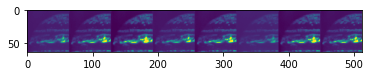

In [2]:
# Starts here
import glob
from PIL import Image
import astropy.visualization

frames = glob.glob(os.path.join(path_to_images, "*.fits"))

multi_frames_np = load_multiple_LR_HR_imgs_sr(frames[:8])

# Resize frames to IMSIZE
IMSIZE = 256
multi_frames_HR_np = [np.array(Image.fromarray(x).resize((IMSIZE,IMSIZE), Image.ANTIALIAS)) for x in multi_frames_np]
multi_frames_LR_np = [np.array(Image.fromarray(x).resize((IMSIZE//4,IMSIZE//4), Image.ANTIALIAS)) for x in multi_frames_np]
# Reduce resolution by factor of 4

if PLOT:
    stacked = np.expand_dims(np.hstack(multi_frames_LR_np), 0)
    Interval = astropy.visualization.PercentileInterval(99.0)
    stacked = Interval(stacked)
    writer.add_image('Training Frames', torch.tensor(stacked), 0)
    plt.imshow(stacked[0])
    plt.show()

# Set up parameters and net

In [3]:
input_depth = 1
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

num_iter = 100
reg_noise_std = 0.03

In [4]:
net_input = get_noise(input_depth, INPUT, (IMSIZE, IMSIZE)).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet, skip
net = get_net(input_depth, NET_TYPE, pad,
              n_channels=1,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_vars = [np_to_torch(x).type(dtype) for x in multi_frames_LR_np]

downsampler = Downsampler(n_planes=1, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [5]:
def closure():
    global i, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    # Train on a random frame every time by hashing current index
    index = hash(i) % len(img_LR_vars)
    total_loss = mse(out_LR[0,:,:], img_LR_vars[index]) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    #psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    #psnr_HR = compare_psnr(imgs['HR_np'], torch_to_np(out_HR))
    #print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
    #target_loss = compare_mse(imgs['HR_np'], torch_to_np(out_HR))
                      
    # History
    #psnr_history.append([psnr_LR, psnr_HR])
    #training_loss_history.append(total_loss.item())
    #target_loss_history.append(target_loss)

    # TensorBoard History
    #writer.add_scalar('PSNR LR', psnr_LR, i)
    #writer.add_scalar('PSNR HR', psnr_HR, i)
    #writer.add_scalar('Training Loss', total_loss.item(), i)
    #writer.add_scalar('Target Loss', target_loss, i)

    for name, param in net.named_parameters():
        writer.add_histogram('Parameter {}'.format(name), param.flatten(), i)
    
    if PLOT and i % 1 == 0:
        Interval = astropy.visualization.PercentileInterval(99.0)
        out_HR_np = Interval(torch_to_np(out_HR))[0]
        out_LR_np = torch_to_np(out_LR)
        
        Interval = astropy.visualization.PercentileInterval(99.0)
        images = [np.expand_dims(np.hstack([Interval(x), out_HR_np]), 0) for x in multi_frames_HR_np]
        images_torch = [torch.from_numpy(x) for x in images]
        for j in range(len(images_torch)):
            writer.add_image('Training frame {}'.format(j), images_torch[j], i)
        #plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)
    
    print("{}  {}".format(i, index))
    i += 1
    
    return total_loss

In [6]:
psnr_history = [] 
training_loss_history = []
target_loss_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
print("Iteration / Frame used")
optimize(OPTIMIZER, p, closure, LR, num_iter)
writer.close()

Iteration / Frame used
Starting optimization with ADAM


/Users/nat/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0  0
1  1
2  2
3  3
4  4
5  5
6  6
7  7
8  0
9  1
10  2
11  3
12  4
13  5
14  6
15  7
16  0
17  1
18  2
19  3
20  4
21  5
22  6
23  7
24  0
25  1
26  2
27  3
28  4
29  5
30  6
31  7
32  0
33  1
34  2
35  3
36  4
37  5
38  6
39  7
40  0
41  1
42  2
43  3
44  4
45  5
46  6
47  7
48  0
49  1
50  2
51  3
52  4
53  5
54  6
55  7
56  0
57  1
58  2
59  3
60  4
61  5
62  6
63  7
64  0
65  1
66  2
67  3
68  4
69  5
70  6
71  7
72  0
73  1
74  2
75  3
76  4
77  5
78  6
79  7
80  0
81  1
82  2
83  3
84  4
85  5
86  6
87  7
88  0
89  1
90  2
91  3
92  4
93  5
94  6
95  7
96  0
97  1
98  2
99  3


In [7]:
# Launch tensorboard to review results
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 41282), started 1:28:44 ago. (Use '!kill 41282' to kill it.)